In [ ]:
import os
import time
import glob
import copy
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.transforms as tt

In [ ]:
if not os.path.exists('./models'):
  os.mkdir('./models')

if not os.path.exists('./configs'):
  os.mkdir('./configs')

In [ ]:
# Define the transforms
train_transforms = tt.Compose([
  tt.RandomHorizontalFlip(p=0.5),
  tt.ToTensor(),
  tt.Normalize(mean=[0.286], std=[0.126])
])

test_transforms = tt.Compose([
  tt.ToTensor(),
  tt.Normalize(mean=[0.286], std=[0.126])
])

# Load Data

In [ ]:
# Download the data if not available and transform to tensor
data = torchvision.datasets.FashionMNIST(root='./data/fashion',
                                         train=True,
                                         download=True,
                                         transform=train_transforms)

test = torchvision.datasets.FashionMNIST(root='./data/fashion',
                                         train=False,
                                         download=True,
                                         transform=test_transforms)

Extracting ./data/fashion/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw


Extracting ./data/fashion/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw



Extracting ./data/fashion/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fashion/FashionMNIST/raw


Extracting ./data/fashion/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fashion/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


It loads a tuple of image and its label. The image is one channel (grayscale) with size 28x28

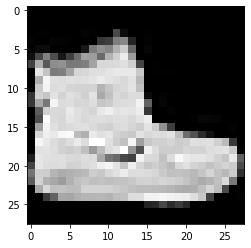

In [ ]:
# Sample image
plt.imshow(data[0][0].squeeze(), cmap='gray')

In [ ]:
# Print first 30 labels. Appears that they are already shuffled
print([x[1] for x in data][:30])

[9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4]


## Train/Val Split

In [ ]:
val_size = 0.2
n = len(data)
n_train = int(n * (1-val_size))
n_val = n - n_train
train, val = random_split(data, [n_train, n_val])

print(f"Train: {len(train)} images")
print(f"Val: {len(val)} images")

Train: 48000 images
Val: 12000 images


# Define Model

In [ ]:
class Network(nn.Module):
  '''
  Neural network with similar architecture to LeNet with some personal touch
  '''
  def __init__(self, n_classes=10, conv_c=[12, 24], fc_c=[256, 128, 64]):
    '''
    :param n_classes: Number of classes, Fashion-MNIST has 10
    :param conv_c: Convolution channels, list
    :param fc_c: Fully-connected channels, list
    Can be expanded to allow dynamic number of convolutional/FC layers
    '''
    super().__init__()

    self._conv_c = conv_c
    self._fc_c = fc_c

    self.conv1 = nn.Conv2d(1, conv_c[0], kernel_size=5)  # 24x24
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # 12x12
    self.conv2 = nn.Conv2d(conv_c[0], conv_c[1], kernel_size=5) # 8x8

    self.drop1 = nn.Dropout2d(p=0.3)
    self.drop2 = nn.Dropout(p=0.3)

    self.fc1 = nn.Linear(conv_c[1]*8*8, fc_c[0])
    self.fc2 = nn.Linear(fc_c[0], fc_c[1])
    self.fc3 = nn.Linear(fc_c[1], fc_c[2])
    self.out = nn.Linear(fc_c[2], n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = self.drop1(x)

    x = self.conv2(x)
    x = F.relu(x)

    x = x.reshape(-1, self._conv_c[1]*8*8)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.drop2(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.drop2(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.out(x)

    return x

In [ ]:
class NetworkTrainer(object):
  '''
  Training manager for the network, allows learning rate scheduling, training,
  collection, visualisation, and saving of results.
  '''
  def __init__(self, net, criterion, device, optimizer='sgd'):
    _run_time = int(time.time())
    self._path = f"./models/{_run_time}.pt"
    self._config_path = f"./configs/{_run_time}.pkl"

    self.net = net
    self.criterion = criterion
    self.loss = []
    self.acc = []
    self.val_loss = []
    self.val_acc = []
    self.results = None

    self.current_epoch = 0
    if optimizer.lower() == 'sgd':
      self.optimizer = optim.SGD(self.net.parameters(),
                                 self.lr_scheduler(optimizer),
                                 momentum=0.8)
    elif optimizer.lower() == 'adam':
      self.optimizer = optim.Adam(self.net.parameters(),
                                  self.lr_scheduler(optimizer))
    else:
      print('Invalid optimizer name. Using Adam.')
      self.optimizer = optim.Adam(self.net.parameters(),
                                  self.lr_scheduler(optimizer))

  def _get_results(self):
    '''
    Utility function to save results after training
    :return: Results of training in pandas DataFrame
    '''
    results = pd.DataFrame(
      {x: getattr(self, x) for x in ['loss', 'acc', 'val_loss', 'val_acc']}
    )
    results.columns = ['TrainLoss', 'TrainAcc', 'ValLoss', 'ValAcc']
    results.index = results.index + 1
    results.rename_axis('Epoch', inplace=True)

    return results

  def lr_scheduler(self, optimizer):
    '''
    Schedule the learning rate throughout increasing epochs
    :param optimizer: Name of optimizer as initialized in the main object
    :return: Learning rate according the epoch
    '''
    learning_rates = [1e-4, 6e-5, 3e-5, 1e-5]
    if optimizer.lower() == 'sgd':
      learning_rates = [x*10 for x in learning_rates]
    if self.current_epoch < 10:
        return learning_rates[0]
    elif self.current_epoch < 15:
        return learning_rates[1]
    elif self.current_epoch < 20:
        return learning_rates[2]
    else:
        return learning_rates[3]

  def train(self, loaders, epochs, early_stop=True, patience=3, silent=False):
    '''
    Main trainer of the network
    :params loaders: Train/val loader dictionary
    :params epochs: Number of epochs to train
    :params early_stop: Early stopping toggle
    :params patience: Early stopping patience
    :params silent: Whether to print training progress to stdout
    '''
    for epoch in range(epochs):
      # Start training one epoch
      epoch_start = time.time()
      self.current_epoch += 1

      if not silent:
        print(f"Epoch {epoch + 1}/{epochs}")
        print('-' * 10)

      # Training Phase
      self.net.train()

      # Reset mini-batch losses
      losses = []
      n_correct = 0
      n_images = 0

      for images, labels in loaders['train']:
        images = images.to(device)
        labels = labels.to(device)
        pred = self.net(images)
        loss = self.criterion(pred, labels)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Record loss and accuracy
        losses.append(loss.item())
        # Add number of correct prediction
        n_correct += pred.argmax(dim=1).eq(labels).sum().item()
        n_images += len(labels)
      
      epoch_loss = sum(losses)/len(losses)
      epoch_acc = n_correct/n_images
      self.loss.append(epoch_loss)
      self.acc.append(epoch_acc)

      # Evaluation Phase
      self.net.eval()

      for images, labels in loaders['val']:
        images = images.to(device)
        labels = labels.to(device)
        pred = self.net(images)
        val_loss = self.criterion(pred, labels).item()

        self.optimizer.zero_grad()

        n_correct = pred.argmax(dim=1).eq(labels).sum().item()
        n_images = len(labels)

      val_acc = n_correct/n_images
      self.val_loss.append(val_loss)
      self.val_acc.append(val_acc)

      if not silent:
        print(f"Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Train Acc: {epoch_acc:.4f} | Val Acc: {val_acc:.4f}")
        print(f"Epoch Time: {time.time() - epoch_start:.2f}s\n")

      # Model Checkpoint
      if val_loss == min(self.val_loss):
        torch.save(self.net.state_dict(), self._path)

      # Early Stopping
      if early_stop:
        # To check last few validation set losses
        val_loss_check = self.val_loss[-(patience + 1):]
        if (epoch >= patience) and (val_loss_check[0] == min(val_loss_check)):
          print("Early stopping triggered.")
          break

      # Save Results
      self.results = self._get_results()

  def visualize_results(self):
    '''
    Method to visualize training curve
    '''
    if self.results is None:
      print("Run the model to get results.")
    else:
      _, ax = plt.subplots(1, 2, figsize=(14, 5))
      self.results[['TrainLoss', 'ValLoss']].plot(ax=ax[0], title='CE Loss')
      self.results[['TrainAcc', 'ValAcc']].plot(ax=ax[1], title='Accuracy')

# Train
Idea
* Training might be made faster by converting float32 to float16.
* Using more feature maps generally improve performance, though training time and model size are adversely affected.

In [ ]:
# Config
net_kwargs = {'conv_c': [32, 64], 'fc_c': [256, 128, 64]}
lr = 1e-4
batch_size = 32

In [ ]:
# Define loader to allow mini-batch training
loaders = {'train': DataLoader(dataset=train, batch_size=batch_size),
           'val': DataLoader(dataset=val, batch_size=len(val)),
           'test': DataLoader(dataset=test, batch_size=len(test))}

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

net = Network(n_classes=10, **net_kwargs).to(device)
criterion = nn.CrossEntropyLoss()

trainer = NetworkTrainer(net, criterion, device, optimizer='adam')
trainer.train(loaders, epochs=50, early_stop=True, patience=8, silent=False)

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


Epoch 1/50
----------
Train Loss: 0.8328 | Val Loss: 0.5091
Train Acc: 0.6959 | Val Acc: 0.8034
Epoch Time: 15.50s

Epoch 2/50
----------
Train Loss: 0.5350 | Val Loss: 0.4061
Train Acc: 0.8046 | Val Acc: 0.8485
Epoch Time: 14.98s

Epoch 3/50
----------
Train Loss: 0.4571 | Val Loss: 0.3594
Train Acc: 0.8382 | Val Acc: 0.8668
Epoch Time: 15.49s

Epoch 4/50
----------
Train Loss: 0.4099 | Val Loss: 0.3363
Train Acc: 0.8542 | Val Acc: 0.8756
Epoch Time: 15.10s

Epoch 5/50
----------
Train Loss: 0.3758 | Val Loss: 0.3151
Train Acc: 0.8669 | Val Acc: 0.8848
Epoch Time: 14.93s

Epoch 6/50
----------
Train Loss: 0.3524 | Val Loss: 0.2959
Train Acc: 0.8744 | Val Acc: 0.8916
Epoch Time: 15.15s

Epoch 7/50
----------
Train Loss: 0.3333 | Val Loss: 0.2876
Train Acc: 0.8814 | Val Acc: 0.8950
Epoch Time: 15.45s

Epoch 8/50
----------
Train Loss: 0.3161 | Val Loss: 0.2802
Train Acc: 0.8867 | Val Acc: 0.8982
Epoch Time: 15.16s

Epoch 9/50
----------
Train Loss: 0.3037 | Val Loss: 0.2704
Train Acc: 0

In [ ]:
# Save config
config = {'lr': lr, 'conv_c': net_kwargs['conv_c'], 'fc_c': net_kwargs['fc_c'],
          'batch_size': batch_size}
with open(trainer._config_path, 'wb') as f:
  pickle.dump(config, f)

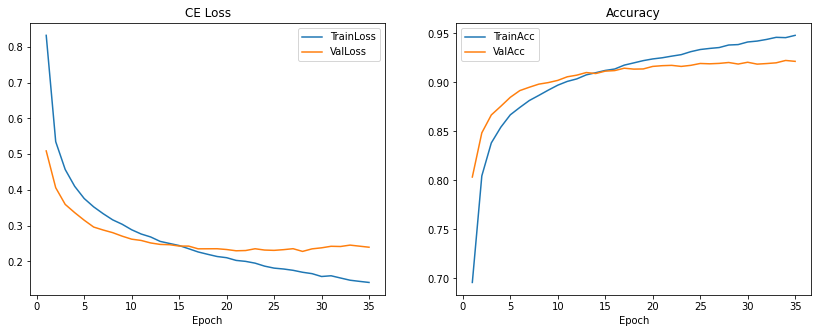

In [ ]:
trainer.visualize_results()

In [ ]:
trainer.results.tail(10)

,TrainLoss,TrainAcc,ValLoss,ValAcc
Epoch,,,,
26,0.178432,0.934604,0.232599,0.918917
27,0.174778,0.935500,0.235314,0.919333
28,0.169314,0.938083,0.227713,0.920250
29,0.165405,0.938521,0.234847,0.918667
30,0.157430,0.941167,0.237728,0.920500
31,0.159499,0.942104,0.242054,0.918583
32,0.153203,0.943792,0.241451,0.919167
33,0.147040,0.945917,0.245347,0.919917
34,0.143808,0.945604,0.242374,0.922333


In [ ]:
print(f"Number of Parameters: {sum(p.numel() for p in net.parameters())}")

Number of Parameters: 1142730


# Evaluate Test Set

In [ ]:
load_saved_model = False

models = glob.glob('./models/*.pt')
print(models)

['./models/1596373718.pt']


In [ ]:
net = copy.deepcopy(trainer.net)

if load_saved_model:
  net.load_state_dict(torch.load(models[-1]))

for images, labels in loaders['test']:
  images = images.to(device)
  labels = labels.to(device)
  pred = net(images)
  test_loss = trainer.criterion(pred, labels).item()

  trainer.optimizer.zero_grad()

  n_correct = pred.argmax(dim=1).eq(labels).sum().item()
  n_images = len(labels)

test_acc = n_correct/n_images
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 0.2652 | Test Acc: 0.9175


# Ensemble (Optional)

In [ ]:
X = np.array([np.array(x[0]).ravel() for x in data])
y = np.array([x[1] for x in data])

X_test = np.array([np.array(x[0]).ravel() for x in test])
y_test = np.array([x[1] for x in test])

In [ ]:
train_rf = False
save_rf = False

## CNN

In [ ]:
pred_cnn = np.array(F.softmax(pred, dim=1).detach().cpu())

## Random Forest Classifier
Random Forest model could be very large (100M+) and training time is slow. Not recommended unless a small boost in performance is critical. Ensembles on average perform 0.0-0.5% better than CNN by itself.

Here, the number of estimators is 100, and provides a decent performance boost. Number of estimators may be increased given the tradeoff is well-understood.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

if train_rf or not os.path.exists('./models/randomforest.sav'):
  start_time = time.time()
  rf = RandomForestClassifier(criterion='entropy', n_estimators=100,
                              max_depth=50, n_jobs=-1)
  rf.fit(X, y)
  pred_rf = rf.predict_proba(X_test)
  end_time = time.time()
  print(f"Elapsed: {end_time - start_time:.2f}s")

  if save_rf:
    with open('./models/randomforest.sav', 'wb') as f:
      pickle.dump(rf, f)
else:
  with open('./models/randomforest.sav', 'rb') as f:
    rf = pickle.load(f)
    pred_rf = rf.predict_proba(X_test)

## Combined

In [ ]:
ens_acc = np.mean(np.argmax(pred_cnn + pred_rf, axis=1) == y_test)

In [ ]:
print(f"Ensemble Acc: {ens_acc:.4f}")

Ensemble Acc: 0.9161
